# Predictive Modeling for Patient Readmission

## Introduction

This notebook aims to build a predictive model to determine whether a patient is likely to be readmitted to the hospital. The steps include data loading, exploration, preprocessing, feature engineering, model training, and evaluation. The goal is to accurately identify high-risk patients, minimize missed readmissions, and provide actionable insights for hospital decision-making.

## 1. Importing Libraries and Loading Data

In this section, we import necessary Python libraries for data manipulation, visualization, feature selection, model training, and evaluation.

### Next Steps:

Load the dataset and check for missing values.

Understand the structure of the data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


In [4]:
df = pd.read_csv(r'C:\Users\ank30\OneDrive\Projects\Project1\Healthcare.csv')

## 2. Data Exploration

Here, we perform an initial analysis of the dataset by checking for missing values, data types, and basic statistics.

### Next Steps:

Identify columns with missing data.

Understand the summary statistics of numerical features.

In [6]:
df.isnull().sum()

Patient ID           0
Age                  0
Gender               0
Admission Date       0
Discharge Date       0
Diagnosis            0
Treatment Outcome    0
Readmission          0
dtype: int64

In [7]:
df.dtypes

Patient ID            int64
Age                   int64
Gender               object
Admission Date       object
Discharge Date       object
Diagnosis            object
Treatment Outcome    object
Readmission          object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient ID         100 non-null    int64 
 1   Age                100 non-null    int64 
 2   Gender             100 non-null    object
 3   Admission Date     100 non-null    object
 4   Discharge Date     100 non-null    object
 5   Diagnosis          100 non-null    object
 6   Treatment Outcome  100 non-null    object
 7   Readmission        100 non-null    object
dtypes: int64(2), object(6)
memory usage: 6.4+ KB


In [9]:
df.describe()

,Patient ID,Age
count,100.000000,100.000000
mean,50.500000,52.430000
std,29.011492,20.375394
min,1.000000,18.000000
25%,25.750000,37.000000
50%,50.500000,53.000000
75%,75.250000,67.250000
max,100.000000,88.000000


In [10]:
df['Admission Date']= pd.to_datetime(df['Admission Date'])
df['Discharge Date']= pd.to_datetime(df['Discharge Date'])
df.head()

,Patient ID,Age,Gender,Admission Date,Discharge Date,Diagnosis,Treatment Outcome,Readmission
0,1,62,Female,2023-03-18,2023-04-01,Pneumonia,Deteriorated,No
1,2,65,Male,2023-03-20,2023-03-26,Breast Cancer,Deteriorated,No
2,3,82,Female,2023-03-20,2023-03-21,Pneumonia,Recovered,No
3,4,85,Male,2023-03-13,2023-03-22,Heart Attack,Improved,No
4,5,85,Female,2023-03-27,2023-04-02,Appendicitis,No Change,No


In [11]:
df['Stay Days'] = df['Discharge Date']-df['Admission Date']
df.head()

,Patient ID,Age,Gender,Admission Date,Discharge Date,Diagnosis,Treatment Outcome,Readmission,Stay Days
0,1,62,Female,2023-03-18,2023-04-01,Pneumonia,Deteriorated,No,14 days
1,2,65,Male,2023-03-20,2023-03-26,Breast Cancer,Deteriorated,No,6 days
2,3,82,Female,2023-03-20,2023-03-21,Pneumonia,Recovered,No,1 days
3,4,85,Male,2023-03-13,2023-03-22,Heart Attack,Improved,No,9 days
4,5,85,Female,2023-03-27,2023-04-02,Appendicitis,No Change,No,6 days


In [12]:
df['Stay Days'] = df['Stay Days'].dt.days
df.head()

,Patient ID,Age,Gender,Admission Date,Discharge Date,Diagnosis,Treatment Outcome,Readmission,Stay Days
0,1,62,Female,2023-03-18,2023-04-01,Pneumonia,Deteriorated,No,14
1,2,65,Male,2023-03-20,2023-03-26,Breast Cancer,Deteriorated,No,6
2,3,82,Female,2023-03-20,2023-03-21,Pneumonia,Recovered,No,1
3,4,85,Male,2023-03-13,2023-03-22,Heart Attack,Improved,No,9
4,5,85,Female,2023-03-27,2023-04-02,Appendicitis,No Change,No,6


In [13]:
df = df.drop(columns=['Admission Date', 'Discharge Date', 'Patient ID'])

## 3. Data Preprocessing

We encode categorical variables, scale numerical features, and perform any necessary transformations to prepare the dataset for modeling.

### Next Steps:

Apply label encoding or one-hot encoding for categorical features.

Normalize numerical variables.

In [15]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Readmission'] = label_encoder.fit_transform(df['Readmission'])

In [16]:
df = pd.get_dummies(df, columns = ['Diagnosis', 'Treatment Outcome'], drop_first=True)

In [17]:
numerical_features = ['Age', 'Stay Days']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [18]:
df.head()

,Age,Gender,Readmission,Stay Days,Diagnosis_Breast Cancer,Diagnosis_Fracture,Diagnosis_Heart Attack,Diagnosis_Pneumonia,Treatment Outcome_Improved,Treatment Outcome_No Change,Treatment Outcome_Recovered
0,0.472050,0,0,1.956782,False,False,False,True,False,False,False
1,0.620029,1,0,-0.418674,True,False,False,False,False,False,False
2,1.458571,0,0,-1.903335,False,False,False,True,False,False,True
3,1.606550,1,0,0.472122,False,False,True,False,True,False,False
4,1.606550,0,0,-0.418674,False,False,False,False,False,True,False


In [19]:
df['Readmission'].value_counts()

Readmission
0    81
1    19
Name: count, dtype: int64

## 4. Feature Importance

To improve model performance, we select the most relevant features using statistical methods such as Correlational matrix and random Forest.


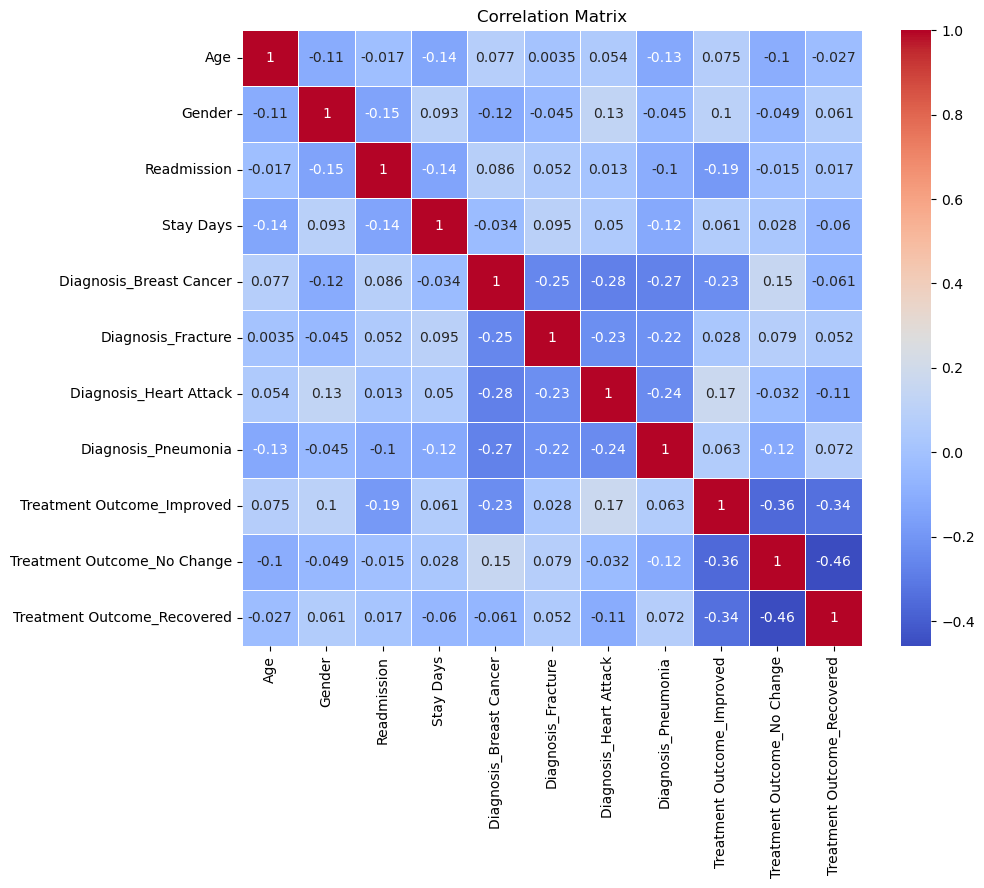

In [21]:
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

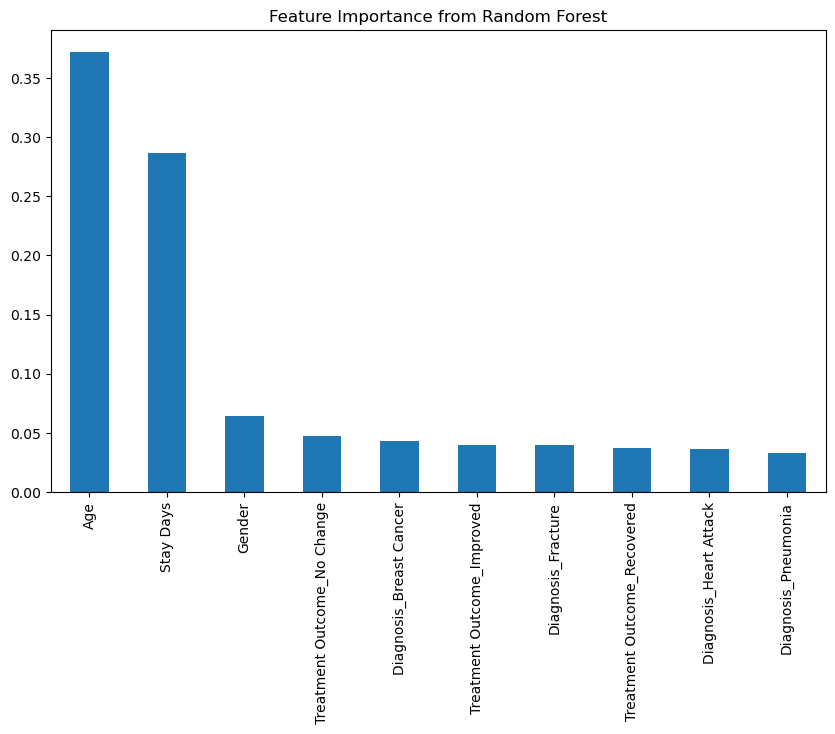

Feature Importance Scores:
Age                            0.371742
Stay Days                      0.286415
Gender                         0.064197
Treatment Outcome_No Change    0.047353
Diagnosis_Breast Cancer        0.043167
Treatment Outcome_Improved     0.040258
Diagnosis_Fracture             0.040224
Treatment Outcome_Recovered    0.037258
Diagnosis_Heart Attack         0.036660
Diagnosis_Pneumonia            0.032727
dtype: float64


In [22]:
X = df.drop(columns=['Readmission'])  
y = df['Readmission']  

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_importance.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance from Random Forest')
plt.show()

print("Feature Importance Scores:")
print(feature_importance)

## 5.Splitting the Data

We split the dataset into training and testing sets to evaluate the model effectively.

### Next Steps:

Ensure the train-test split maintains the proportion of target classes using stratification.

In [24]:
X = df.drop(columns=['Readmission', 'Stay Days']) 
y = df['Readmission']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
y.value_counts()

Readmission
0    81
1    19
Name: count, dtype: int64

## 6. Handling Class Imbalance with SMOTE

Since hospital readmission data is often imbalanced, we use SMOTE to oversample the minority class and balance the dataset.

### Next Steps:

Apply SMOTE to generate synthetic samples.

Re-evaluate class distribution.

In [27]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X,y)

y_sm.value_counts()

Readmission
0    81
1    81
Name: count, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm)

In [29]:
y_train.value_counts()

Readmission
1    65
0    64
Name: count, dtype: int64

## 9. Model Training

We train multiple machine learning models and compare their performance.

### Next Steps:

Train different models like Logistic Regression, Random Forest, and SVM.

Optimize hyperparameters.

### LOGISTIC REGRESSION

In [32]:
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, C=0.5)

model_lr.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [33]:
y_predicted_lr = model_lr.predict(X_test)

In [34]:
model_lr.score(X_test, y_test)

0.7575757575757576

Text(33.22222222222222, 0.5, 'True')

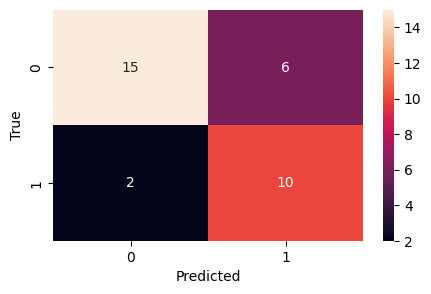

In [35]:

cm_lr = confusion_matrix(y_predicted_lr, y_test)

plt.figure(figsize=(5,3))
sns.heatmap(cm_lr, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [36]:
print("Classification Report:")
print(classification_report(y_test, y_predicted_lr))

acc_lr = accuracy_score(y_test,y_predicted_lr)
print('Accuracy:', acc_lr)

precision_lr = precision_score(y_test, y_predicted_lr)
print(f"Precision: {precision_lr:.2f}")

recall_lr = recall_score(y_test, y_predicted_lr)
print(f"Recall: {recall_lr:.2f}")

f1_lr = f1_score(y_test, y_predicted_lr)
print(f"F1-Score: {f1_lr:.2f}")

y_pred_prob_lr = model_lr.predict_proba(X_test)[:,1]
print("AUC-ROC:",y_pred_prob_lr)

auc_lr = roc_auc_score(y_test, y_pred_prob_lr)
print(f"AUC Score: {auc_lr:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        17
           1       0.83      0.62      0.71        16

    accuracy                           0.76        33
   macro avg       0.77      0.75      0.75        33
weighted avg       0.77      0.76      0.75        33

Accuracy: 0.7575757575757576
Precision: 0.83
Recall: 0.62
F1-Score: 0.71
AUC-ROC: [0.84327341 0.21645163 0.81118907 0.39767068 0.37260368 0.23342497
 0.36201445 0.47301119 0.29950587 0.85926014 0.32273684 0.307281
 0.30052935 0.40501707 0.3082992  0.25872379 0.80295638 0.75213473
 0.75777691 0.36354471 0.3974392  0.49596413 0.19925292 0.64322414
 0.16704095 0.3794645  0.59221412 0.75341981 0.84691364 0.71856305
 0.44424435 0.58752839 0.46183077]
AUC Score: 0.80


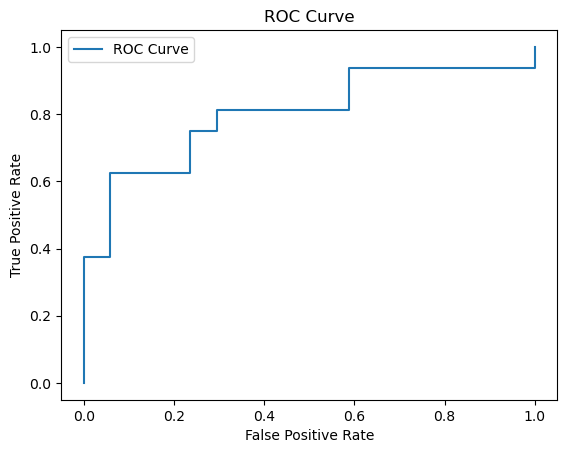

In [37]:
fpr_lr, tpr_lr, _lr = roc_curve(y_test, y_pred_prob_lr)

plt.plot(fpr_lr, tpr_lr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [38]:
y_pred_prob_lr

array([0.84327341, 0.21645163, 0.81118907, 0.39767068, 0.37260368,
       0.23342497, 0.36201445, 0.47301119, 0.29950587, 0.85926014,
       0.32273684, 0.307281  , 0.30052935, 0.40501707, 0.3082992 ,
       0.25872379, 0.80295638, 0.75213473, 0.75777691, 0.36354471,
       0.3974392 , 0.49596413, 0.19925292, 0.64322414, 0.16704095,
       0.3794645 , 0.59221412, 0.75341981, 0.84691364, 0.71856305,
       0.44424435, 0.58752839, 0.46183077])

## RANDOM FOREST CLASSIFICATION

In [40]:
model_RC = RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=42)

model_RC.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=42)

In [41]:
y_predicted_RC = model_RC.predict(X_test)

In [42]:
model_RC.score(X_test, y_test)

0.8484848484848485

Text(33.22222222222222, 0.5, 'True')

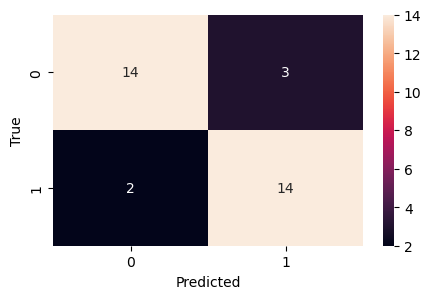

In [43]:
cm_RC = confusion_matrix(y_test, y_predicted_RC)

plt.figure(figsize=(5,3))
sns.heatmap(cm_RC, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [44]:
print("📊 Classification Report - Random Forest:")
print(classification_report(y_test, y_predicted_RC))

acc_RC = accuracy_score(y_test, y_predicted_RC)

precision_RC = precision_score(y_test, y_predicted_RC)
print(f"Precision: {precision_RC:.2f}")

recall_RC = recall_score(y_test, y_predicted_RC)
print(f"Recall: {recall_RC:.2f}")

f1_RC = f1_score(y_test, y_predicted_RC)
print(f"F1-Score: {f1_RC:.2f}")

y_pred_prob_RC = model_RC.predict_proba(X_test)[:,1]
print("AUC-ROC:",y_pred_prob_RC)

auc_RC = roc_auc_score(y_test, y_pred_prob_RC)
print(f"AUC Score: {auc_RC:.2f}")


📊 Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.82      0.88      0.85        16

    accuracy                           0.85        33
   macro avg       0.85      0.85      0.85        33
weighted avg       0.85      0.85      0.85        33

Precision: 0.82
Recall: 0.88
F1-Score: 0.85
AUC-ROC: [0.85 0.05 0.99 0.74 0.37 0.02 0.38 0.59 0.34 0.91 0.4  0.1  0.31 0.4
 0.9  0.02 0.9  0.99 1.   0.07 0.07 0.16 0.24 0.89 0.09 0.33 0.99 1.
 0.82 0.98 0.76 0.78 0.82]
AUC Score: 0.89


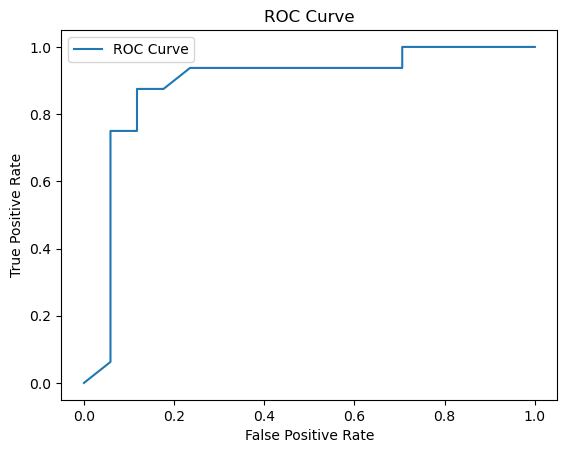

In [45]:
fpr_RC, tpr_RC, _RC = roc_curve(y_test, y_pred_prob_RC)

plt.plot(fpr_RC, tpr_RC, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## GRADIENT BOOSTING CLASSIFIER

In [47]:

model_GB = GradientBoostingClassifier(n_estimators=150, learning_rate=0.7,random_state=42)

model_GB.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.7, n_estimators=150, random_state=42)

In [48]:
y_pred_GB = model_GB.predict(X_test)

In [49]:
model_GB.score(X_test, y_test)

0.7575757575757576

Text(33.22222222222222, 0.5, 'True')

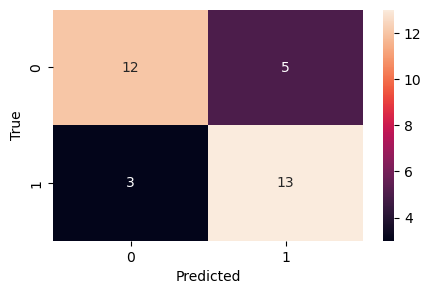

In [50]:
cm_GB= confusion_matrix(y_test, y_pred_GB)

plt.figure(figsize=(5,3))
sns.heatmap(cm_GB, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [51]:
print("📊 Classification Report - Gradient Boost:")
print(classification_report(y_test, y_pred_GB))

acc_GB = accuracy_score(y_test, y_pred_GB)

precision_GB = precision_score(y_test, y_pred_GB)
print(f"Precision: {precision_GB:.2f}")

recall_GB = recall_score(y_test, y_pred_GB)
print(f"Recall: {recall_GB:.2f}")

f1_GB = f1_score(y_test, y_pred_GB)
print(f"F1-Score: {f1_GB:.2f}")

y_pred_prob_GB = model_GB.predict_proba(X_test)[:,1]
print("AUC-ROC:",y_pred_prob_GB)

auc_GB = roc_auc_score(y_test, y_pred_prob_GB)
print(f"AUC Score: {auc_GB:.2f}")


📊 Classification Report - Gradient Boost:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        17
           1       0.72      0.81      0.76        16

    accuracy                           0.76        33
   macro avg       0.76      0.76      0.76        33
weighted avg       0.76      0.76      0.76        33

Precision: 0.72
Recall: 0.81
F1-Score: 0.76
AUC-ROC: [9.99999113e-01 4.43853759e-08 9.99999001e-01 2.60252392e-01
 4.21087459e-01 7.53283420e-09 9.99922905e-01 9.85826884e-01
 1.04846179e-06 9.99999840e-01 1.15939813e-03 9.19264703e-04
 2.52808557e-03 7.45825490e-01 9.99941394e-01 1.34779651e-05
 9.99999993e-01 9.99999763e-01 1.00000000e+00 1.87658115e-06
 1.08671544e-05 1.24108444e-04 2.59331553e-10 9.99998042e-01
 5.89650255e-03 3.89196142e-01 9.99981835e-01 9.99999967e-01
 5.91278619e-01 9.99999999e-01 9.99981618e-01 9.37765393e-01
 9.95033239e-01]
AUC Score: 0.86


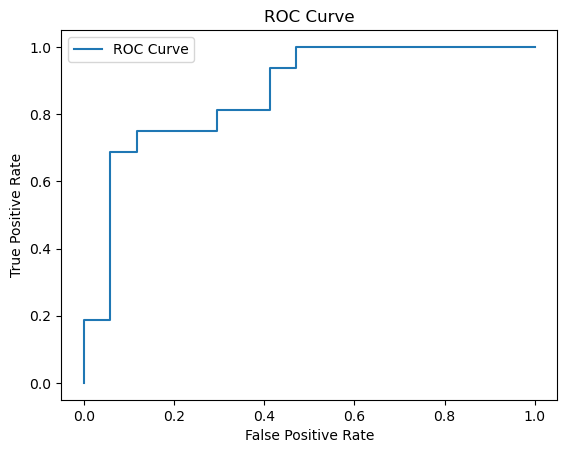

In [52]:
fpr_GB, tpr_GB, _GB = roc_curve(y_test, y_pred_prob_GB)

plt.plot(fpr_GB, tpr_GB, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## STANDARD VECTOR CLASSIFIER

In [54]:
model_SVC = SVC(C=2.0, gamma='scale', probability=True, random_state=42, class_weight='balanced')
model_SVC.fit(X_train, y_train)

SVC(C=2.0, class_weight='balanced', probability=True, random_state=42)

In [55]:
y_pred_SVC = model_SVC.predict(X_test)

In [56]:
model_SVC.score(X_test, y_test)

0.8484848484848485

Text(33.22222222222222, 0.5, 'True')

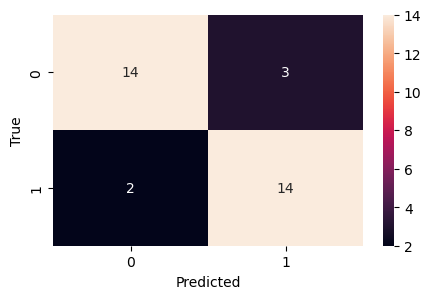

In [57]:
cm_SVC= confusion_matrix(y_test, y_pred_SVC)

plt.figure(figsize=(5,3))
sns.heatmap(cm_SVC, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [58]:
print("📊 Classification Report - STANDARD VECTOR CLASSIFIER:")
print(classification_report(y_test, y_pred_SVC))

acc_SVC = accuracy_score(y_test, y_pred_SVC)

precision_SVC = precision_score(y_test, y_pred_SVC)
print(f"Precision: {precision_SVC:.2f}")

recall_SVC = recall_score(y_test, y_pred_SVC)
print(f"Recall: {recall_SVC:.2f}")

f1_SVC = f1_score(y_test, y_pred_SVC)
print(f"F1-Score: {f1_SVC:.2f}")

y_pred_prob_SVC = model_SVC.predict_proba(X_test)[:,1]
print("AUC-ROC:",y_pred_prob_SVC)

auc_SVC = roc_auc_score(y_test, y_pred_prob_SVC)
print(f"AUC Score: {auc_SVC:.2f}")


📊 Classification Report - STANDARD VECTOR CLASSIFIER:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.82      0.88      0.85        16

    accuracy                           0.85        33
   macro avg       0.85      0.85      0.85        33
weighted avg       0.85      0.85      0.85        33

Precision: 0.82
Recall: 0.88
F1-Score: 0.85
AUC-ROC: [0.63290681 0.12449169 0.77054888 0.76530734 0.39067192 0.11974039
 0.58855283 0.27010868 0.41252005 0.81245372 0.43512724 0.2429351
 0.3901413  0.13632268 0.78725021 0.1570243  0.77954727 0.8406792
 0.83533568 0.19558821 0.14761755 0.26142729 0.08987422 0.77000779
 0.18502132 0.31172674 0.81992752 0.84323832 0.56355306 0.79922993
 0.69058276 0.62724781 0.61307596]
AUC Score: 0.89


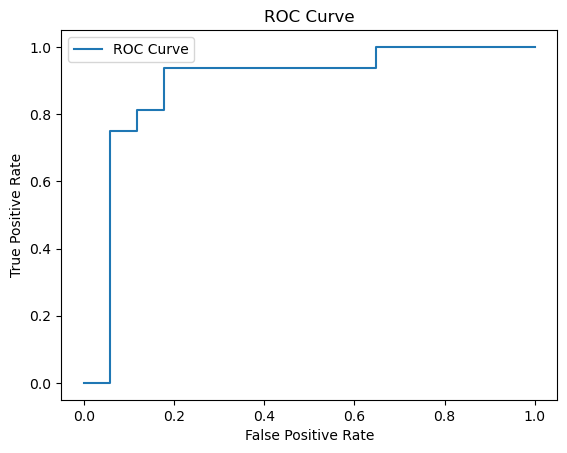

In [59]:
fpr_SVC, tpr_SVC, _SVC = roc_curve(y_test, y_pred_prob_SVC)

plt.plot(fpr_SVC, tpr_SVC, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 8. Model Evaluation

We assess model performance using classification metrics such as accuracy, precision, recall, F1-score, and AUC-ROC.

### Next Steps:

Compare different models.

Identify the best-performing one for deployment.

In [61]:
model_results = {
    "Logistic Regression": [acc_lr, precision_lr, recall_lr, f1_SVC, auc_lr],
    "Random Forest": [acc_RC, precision_RC, recall_RC, f1_RC, auc_RC],
    "Gradient Boosting": [acc_GB, precision_GB, recall_GB, f1_GB, auc_GB],
    "SVM": [acc_SVC, precision_SVC, recall_SVC, f1_SVC, auc_SVC]
}

metrics_df = pd.DataFrame(model_results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

print(metrics_df)

           Logistic Regression  Random Forest  Gradient Boosting       SVM
Accuracy              0.757576       0.848485           0.757576  0.848485
Precision             0.833333       0.823529           0.722222  0.823529
Recall                0.625000       0.875000           0.812500  0.875000
F1-Score              0.848485       0.848485           0.764706  0.848485
AUC-ROC               0.801471       0.886029           0.863971  0.886029


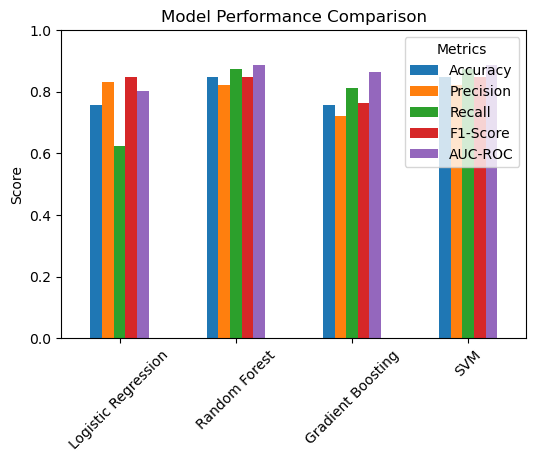

In [62]:
metrics_df.T.plot(kind='bar', figsize=(6, 4))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)  # Metrics are between 0 and 1
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.show()

## Conclusion

After analyzing the performance metrics of all models, Random Forest is selected as the best model for hospital readmission prediction because it offers the best balance of accuracy, recall, and overall model performance. 

1. High Accuracy (0.848)
   Accuracy represents the proportion of correctly classified readmissions and non-readmissions.
   A higher accuracy means the model is making fewer incorrect predictions overall.
   Random Forest outperforms Logistic Regression and Gradient Boosting in this aspect.

2. Best Recall (0.875) – Capturing More Readmissions
   Recall is critical for hospital readmission prediction.
   A high recall means the model is detecting more actual readmissions, which is crucial because missing a readmission can lead to higher medical    costs, worsening patient heath, and regulatory penalties for hospitals.
   Random Forest achieves the highest recall (0.875), meaning it correctly identifies 87.5% of actual readmissions, reducing the risk of missed patients who might need additional care.

3. Strong Precision (0.823)
   Precision measures how many of the predicted readmissions are actually correct.
   While Gradient Boosting has lower precision (0.722), Random Forest maintains a strong 0.823, meaning it minimizes false alarms (incorrectly labeling non-readmitted patients as readmitted).

4. Best F1-Score (0.848) – Balancing Precision & Recall
   F1-Score is the harmonic mean of precision and recall, showing how well the model balances both metrics.
   A high F1-score means the model is performing well in both avoiding false negatives (missed readmissions) and false positives (incorrectly predicting readmissions).
   Random Forest achieves 0.848, the highest among all models.

5. Highest AUC-ROC (0.886) – Strongest Discrimination Ability
   AUC-ROC (Area Under the Curve - Receiver Operating Characteristic) measures how well the model distinguishes between readmitted and non-readmitted patients.
   A value close to 1.0 means the model makes near-perfect predictions.
   Random Forest achieves 0.886, the highest of all models, meaning it can effectively differentiate between patients at risk of readmission and those who are not.

6. Interpretability & Practicality
   Random Forest is easier to interpret than SVM, making it more suitable for healthcare applications where explainability is important.
   It runs efficiently on large datasets and does not require extensive hyperparameter tuning like SVM or Gradient Boosting.
   It can also provide feature importance, helping hospitals understand which factors contribute most to readmissions, leading to better decision-making and targeted interventions.

What This Means for Hospital Readmission Prediction
By deploying Random Forest, hospitals can better identify high-risk patients and take preventive actions (e.g., follow-up care, patient education, medication reviews) to reduce readmission rates.
Minimizing false negatives (missed readmissions) ensures fewer patients return unexpectedly, improving patient outcomes and hospital efficiency.
Maintaining high precision reduces unnecessary interventions, optimizing resource allocation.
Overall, Random Forest offers a reliable, interpretable, and effective model for real-world deployment in hospital settings.